# Image Preprocessing
The data being used in this project comes from the [Kaggle Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018). The goal of this competition is to locate various nuclei within an image and detect each instance of it down to the exact pixel. The dataset consists of RGB images of microscope images. Each image comes with a prelabeled masks for each nuclei in an image. 

The purpose of this notebook is to preprocess the images in such a way that I can create a training and label dataset from this raw data. In order to do this, I resized each image to a uniform size of (256,256,3), while keeping track of it's original dimensions for later reference. For the labels, they are given as a binary mask, one for each instance of a nuclei. Therefore to make prediction simpler, I combined these images into a single mask. While this will fail to detect **instances**, we can use other traditional computer vision methods to split the predicted mask.

Once the images have been formatted, they will be pickled, or simply stored, for quick reading when user later on.

In [1]:
from preprocess_utils import *
import matplotlib.pyplot as plt
import pickle

## Training Images and Labels

Images Read: 0
Images Read: 500
Completed processing 670 images
0


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


500


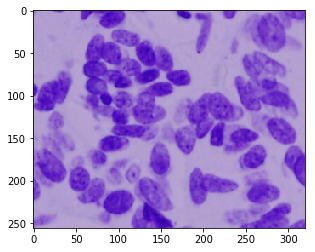

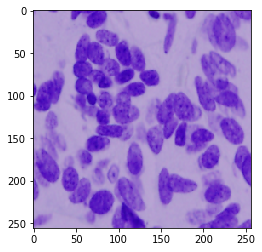

In [28]:
images = read_images("../train_data")
train_X =get_train_images(images gray=True)

print("Pickling...")
pickle.dump(train_X, open('../processed_data/raw_train_images.p', 'wb')) # Write to a pickle file for fast read later.

plt.figure()
plt.imshow(images[list(images.keys())[10]])
plt.figure()
plt.imshow(train_X[10])

del train_X
del images

Masks Read: 0
Masks Read: 500
Completed processing 670 masks
0


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


500


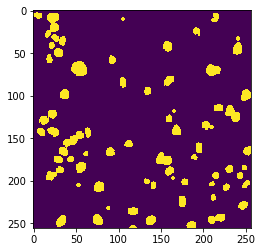

In [26]:
masks = read_masks("../train_data")
train_Y = get_train_labels(masks)
plt.imshow(train_Y[0])

print("Pickling...")
pickle.dump(train_Y, open('../processed_data/raw_train_masks.p', 'wb'))

del train_Y
del masks

## Test Images
These images are separate from training dataset, which have labeled masks associated with them. This dataset is purely for submission purposes.

In [8]:
test_images, test_sizes, img_names = read_test_images("../test_data")
test_X = get_train_images(test_images)
pickle.dump(test_X, open('../processed_data/test_X.p', 'wb'))
pickle.dump(test_sizes, open('../processed_data/test_sizes.p', 'wb'))
pickle.dump(img_names, open('../processed_data/test_img_names.p', 'wb'))

Read 0 image
Completed processing 65 images
0


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


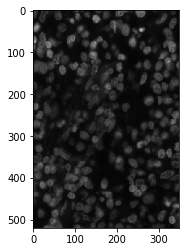

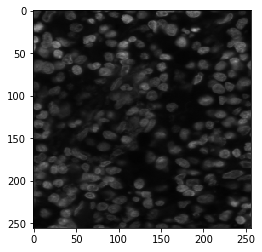

In [6]:
plt.imshow(test_images[list(test_images.keys())[0]])
plt.figure()
plt.imshow(test_X[0])

# RGB to Grayscale training data

Images Read: 0
Images Read: 500
Completed processing 670 images
0


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


500
Pickling...


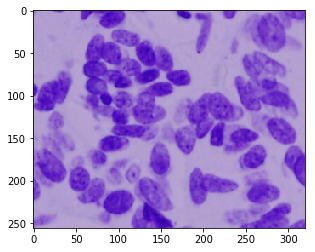

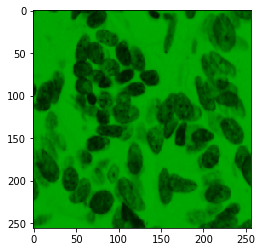

In [5]:
images = read_images("../train_data")
train_X =get_train_images(images, gray=True, shape=(256,256,3))

print("Pickling...")
pickle.dump(train_X, open('../processed_data/gray_train_X.p', 'wb')) # Write to a pickle file for fast read later.

plt.figure()
plt.imshow(images[list(images.keys())[10]])
plt.figure()
plt.imshow(train_X[10])

del train_X
del images

# Weighted Borders

In [4]:
import cv2

In [73]:
def calculate_unet_background_weight(merged_mask, masks, w0=10, q=5,):
    weight = np.zeros(merged_mask.shape)
    # calculate weight for important pixels
    distances = np.array([ndimage.distance_transform_edt(m==0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    # distance to the border of the nearest cell 
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weight = w0 * np.exp(-(d1+d2)**2/(2*q**2)).astype(np.float32)
    weight = 1 + (merged_mask == 0) * weight
    return weight

def map_contour(mask):
    contour_map = np.zeros(mask.shape)
    _,cnt,_ = cv2.findContours(mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    for contour in cnt:
        for coord in contour:
            coord = coord[0]
            contour_map[coord[1],coord[0]] = 1
    return contour_map

def read_masks(path):
    """ Read Images and Masks from Path

        Arguments:
            path

        Return:
            dictionary of masks, indexed by corresponding image name


    """

    masks = {}

    count = 0

    for root,dirs,files in os.walk(path):
        if 'images' in dirs:
            for img_name in listdir(root + '/images'):

                if count % 500 == 0:
                    print("Masks Read: {}".format(count))
                count += 1

                # Read Masks
                submasks = []
                for mask_name in listdir(root + '/masks'):
                    mask_path = root + '/masks/{}'.format(mask_name)
                    if mask_path == '':
                        raise Exception("No Masks found in directory")
                    img = np.asarray(imread(mask_path))
                    contour = map_contour(img)
                    submasks.append((img,contour))
                masks[img_name] = submasks
    print("Completed processing {} masks".format(count))
    return masks

def get_train_labels(submasks):
    masks = {}
    weights = {}
    for key in submasks.keys():
        masks[key] = combine_output_mask(submasks[key])
        weights[key] = calculate_unet_background_weight(masks[key], [mask[0]/255 for mask in submasks[key]])
        weights[key] = (weights[key] - 1) / np.max(weights[key])

    masks = uniform_reshape(masks, (256,256))
    weights = uniform_reshape(weights, (256,256))
    return masks,weights

def combine_output_mask(masks):
    """ Combines multiple masks into a single mask

    Arguments:
        masks: np.array of masks for given image

    Return:
        mask: single mask of joined submasks
    """

    combined = np.round(np.amax([mask[0] for mask in masks], axis=0) / 255)
    contour = np.round(np.amax([mask[1] for mask in masks], axis=0))
    combined = np.subtract(combined,contour)
    
    combined = np.clip(combined, 0,1)

    
    return combined



In [75]:
masks = read_masks("../train_data")
train_Y, weights =get_train_labels(masks)

Masks Read: 0
Masks Read: 500
Completed processing 670 masks
0


/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kenkang/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


500
0
500


In [76]:
pickle.dump(train_Y, open('../processed_data/weighted_train_masks.p', 'wb'))
pickle.dump(weights, open('../processed_data/weighted_train_weights.p', 'wb'))

In [77]:
len(weights)

670